In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd as autograd
from torch import distributions as D

### Comparison of Nearsightedness of Energy Discrepancy, Maximum Likelihood Estimation, and Score Matching

In [2]:
class Mixture_model():
    def __init__(self, distribution_a, distribution_b, weights=0.2):
        self.weights = weights
        self.distribution_a = distribution_a
        self.distribution_b = distribution_b
        
    def set_parameter(self, rho):
        self.weights = rho
        
    def sample(self, n_samples):
        mask = torch.distributions.Bernoulli(torch.tensor([self.weights]))
        index = mask.sample((n_samples,))

        samples_a = self.distribution_a.sample((n_samples,))
        samples_b = self.distribution_b.sample((n_samples,))
        samples = index * samples_a + (1-index) * samples_b
        
        return samples

    def energy(self, x):
        alpha = self.weights

        log_prob_a = self.distribution_a.log_prob(x) + np.log(alpha)
        log_prob_b = self.distribution_b.log_prob(x) + np.log(1-alpha)

        log_probs = torch.cat((log_prob_a.unsqueeze(1), log_prob_b.unsqueeze(1)), 1)

        energy = -torch.logsumexp(log_probs, 1)
        return energy
    
    def negative_loglikelihood(self, data):
        return self.energy(data).mean()

def compute_energy_discrepancy(energy_net, samples, m_particles=4, t_noise=1.0, w_stable=1.0, seed=0):
    device = samples.device
    torch.manual_seed(seed)

    browniani = torch.randn_like(samples).to(device) * np.sqrt(t_noise)
    brownianij = torch.randn(samples.size(0), m_particles, *samples.shape[1:]).to(device) * np.sqrt(t_noise)

    pert_data = samples.unsqueeze(1) + browniani.unsqueeze(1) + brownianij

    pos_energy = energy_net(samples)
    neg_energy = energy_net(pert_data.view(-1, *samples.shape[1:])).view(samples.size(0), -1)
    val = pos_energy - neg_energy
    if w_stable != 0:
        val = torch.cat([val, np.log(w_stable) * torch.ones_like(val[:, :1])], dim=-1)

    loss = val.logsumexp(dim=-1).mean()
    return loss

def compute_score(energy, samples):
    with torch.enable_grad():
        samples = samples.detach()
        samples.requires_grad_(True)
        log_probs = energy(samples).sum()
        return autograd.grad(log_probs, samples)[0]

def fish_divergence(gauss_mixture, data, rho):
    gauss_mixture.set_parameter(0.2)
    energy_truth = gauss_mixture.energy
    gauss_mixture.set_parameter(rho)
    energy_rho = gauss_mixture.energy
    return 0.5 * ((compute_score(energy_rho, data) - compute_score(energy_truth, data))**2).mean()

def maximum_likelihood(gauss_mixture, data, rho):
    gauss_mixture.set_parameter(rho)
    return gauss_mixture.negative_loglikelihood(data)

def energy_discrepancy(gauss_mixture, data, rho, t, seed):
    gauss_mixture.set_parameter(rho)
    return compute_energy_discrepancy(energy_net=gauss_mixture.energy, samples=data, t_noise=t, seed=seed)


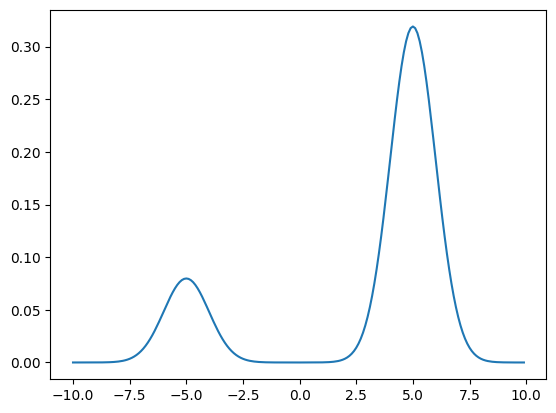

In [3]:
distribution_a = D.Normal(loc = torch.tensor([-5.]), scale = torch.tensor([1.0]))
distribution_b = D.Normal(loc = torch.tensor([5.]), scale = torch.tensor([1.0]))
gauss_mixture = Mixture_model(distribution_a, distribution_b, 0.2)

x = torch.arange(-10., 10., 0.1)
plt.plot(x, np.exp(-gauss_mixture.energy(x)))

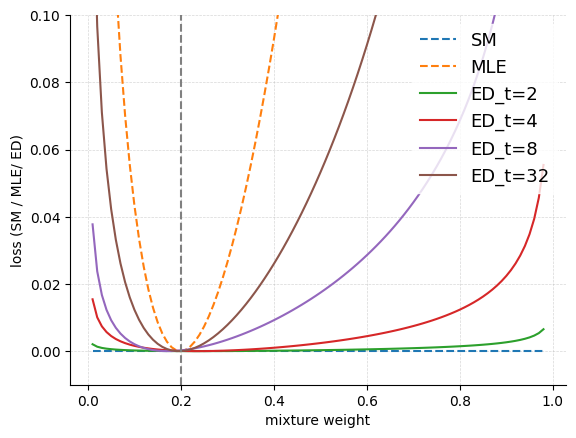

In [4]:
gauss_mixture.set_parameter(0.2)
data = gauss_mixture.sample(4096)

fig, ax = plt.subplots()
rhos = np.arange(0.01, 0.99, 0.01)

losses = np.array([fish_divergence(gauss_mixture, data, rho) for rho in rhos])
ax.plot(rhos, losses, label='SM', linestyle='--')

losses = np.array([maximum_likelihood(gauss_mixture, data, rho) for rho in rhos])
losses = losses - min(losses)   # rescale the losses for better visualization
ax.plot(rhos, losses, label=f'MLE', linestyle='--')

for t in [2, 4, 8, 32]:
    seed = np.random.randint(100000)
    losses = np.array([energy_discrepancy(gauss_mixture, data, rho, t, seed) for rho in rhos])
    losses = losses - min(losses)   # rescale the losses for better visualization
    ax.plot(rhos, losses, label=f'ED_t={t}')

plt.ylim(-0.01, 0.1)
plt.xlabel("mixture weight")
plt.ylabel("loss (SM / MLE/ ED)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvline(0.2, color = 'grey', linestyle = '--')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(fontsize=13, loc='upper right', frameon=True, edgecolor='white')
plt.show()